## Perkenalan

=================================================

   

   Nama  : Mardhya Malik Nurbani
   

   Program ini dirancang untuk menganalisis dataset 'Tweets.csv' yang berasal dari platform Kaggle. Dalam proses pengolahan data, digunakan konsep klasifikasi dengan memanfaatkan Neural Network Architecture (NNA), Natural Language Processing (NLP), serta metode Gated Recurrent Unit (GRU) dan Long Short-Term Memory (LSTM). Tujuannya adalah untuk memprediksi apakah tweet tersebut mengandung kata-kata dengan sentimen negatif, positif, atau netral.

=================================================

## Import Libraries

In [2]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
!pip install pysastrawi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mardhya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mardhya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading

_Source : https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset_ 

In [3]:
#import file P1G5_Set_1_mardhya.csv
df = pd.read_csv('Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


**Insight**: Data yang tertampil merupakan lima data teratas dari dataset. Jika dilihat dari dataset yang ditampilkan, terdapat 4 kolom dataset yang berisikan informasi yang berasal dari Tweets.csv

In [4]:
columns_to_drop = ['textID', 'selected_text']
df.drop(columns=columns_to_drop, inplace=True)

**Insight** : Drop column yang tidak perlu seperti `textID` untuk mempermudah proses prediksi. serta menghapus data text yang sudah clean pada `selected_text` untuk melakukan cleaning text ulang.

In [5]:
df['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

**Insight** : Melaakukan value_count untuk melihat seberapa banyak data pada column `sentiment`, apakah data balance atau tidak. terlihat, bahwa data tidak balance yang didominasi oleh `neutral` .

In [6]:
#menampilkan summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


**Insight**: Dataset yang digunakan memiliki 2 kolom (sesudah dihapus 2 column sebelumnya yg harusnya jumlah total 4 column) dengan total data nya adalah 27480. dengan 2 column bertipe data object. 

In [7]:
#pengecheckan data null yang terdapat pada dataset
df.isnull().sum()

text         1
sentiment    0
dtype: int64

**Insight** : Ditemukan data null sebanyak 1, dan kemudian akan dilakukan proses drop pada data null

In [8]:
df = df.dropna(subset=['text'])
df = df.dropna(subset=['sentiment'])
df.isnull().sum()

text         0
sentiment    0
dtype: int64

**Insigt** : data null sudah dihapus, maka selanjutnya akan dilakukan proses pengechekan data duplicat

In [9]:
#mencari data duplicate pada dataset
duplicates = df[df.duplicated(keep=False)]
df.duplicated().sum()

0

**Insight** : Tidak terdapat data duplicate pada dataset ini

In [10]:
df['label'] = df['sentiment'].replace({'negative' : 0, 'positive' : 1,'neutral' : 2})
df

,text,sentiment,label
0,"I`d have responded, if I were going",neutral,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,my boss is bullying me...,negative,0
3,what interview! leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",negative,0
...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,0
27477,I`ve wondered about rake to. The client has ...,negative,0
27478,Yay good for both of you. Enjoy the break - y...,positive,1
27479,But it was worth it ****.,positive,1


**Insight** : Membuat kolom baru bernama 'label' dalam DataFrame df, di mana nilai-nilai 'negative', 'positive', dan 'neutral' dalam kolom 'sentiment' digantikan dengan 0, 1, dan 2

In [11]:
# cek ukuran dari dataframe
df.shape

(27480, 3)

**Insight** : DataFrame df memiliki 27480 entri dan 3 kolom.

## Text Preprocessing

In [12]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('english')))
stpwds_id.append('oh') # Cara lain dari "stpwds_id = stpwds_id + ['oh']"

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

**Insight** : menyiapkan daftar stopwords dalam bahasa Inggris dan objek stemmer untuk analisis teks dalam konteks bahasa Inggris.

In [13]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

 **Insight** : implementasi fungsi pra-pemrosesan teks dalam bahasa Inggris, yang fungsinya untuk melakukan pengubahan huruf kecil, penghapusan mention, hashtags, newline, whitespace, URL, karakter non-huruf, tokenisasi, penghapusan stopwords, dan stemming, tujuannya untuk membersihkan dan mempersiapkan text untuk dianalisa lebih lanjut.

In [14]:
# Applying Text Preprocessing to the Dataset
df['text_processed'] = df['text'].apply(lambda x: text_preprocessing(x))
df

,text,sentiment,label,text_processed
0,"I`d have responded, if I were going",neutral,2,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,0,sooo sad miss san ego
2,my boss is bullying me...,negative,0,boss bullying
3,what interview! leave me alone,negative,0,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,0,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,0,wish could come see u denver husband lost job ...
27477,I`ve wondered about rake to. The client has ...,negative,0,wondered rake client made clear net force devs...
27478,Yay good for both of you. Enjoy the break - y...,positive,1,yay good enjoy break probably need hectic week...
27479,But it was worth it ****.,positive,1,worth


**Insight** : pra-pemrosesan `teks` (text_preprocessing) pada kolom 'text'. hasilnya akan disimpan pada column baru bernama `text_processed`. langkah ini merupakan proses untuk mempersiapkan analisis lebih lanjut.

In [15]:
df = df.rename(columns={'text_processed': 'text_processed', 'label':'label'})
df['label'] = df['label'].map({0: 0.0, 1: 1.0, 2:2.0})
# # Output first five rows
df.head()

,text,sentiment,label,text_processed
0,"I`d have responded, if I were going",neutral,2.0,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,0.0,sooo sad miss san ego
2,my boss is bullying me...,negative,0.0,boss bullying
3,what interview! leave me alone,negative,0.0,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,0.0,sons put releases already bought


**Insight** : Memetakan nilai dalam kolom 'label' dari {0, 1, 2} menjadi {0.0, 1.0, 2.0} untuk mempermudaha proses EDA

## EDA

<Axes: xlabel='label'>

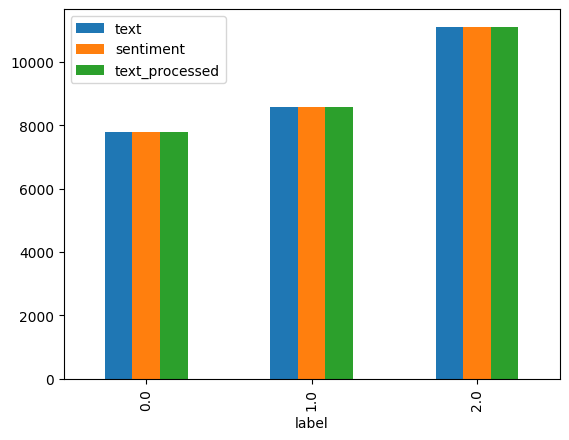

In [16]:
# The distribution of sentiments
df.groupby('label').count().plot(kind='bar')

**Insight** : Menurut data diatas. data dengan sentimen 2.0 (Neutral) memiliki jumlah paling banyak dibandingkan sentimen 1.0 (Positive), dan 0.0 (Negative). jumlah ini sudah terlihat karena data tidak balance

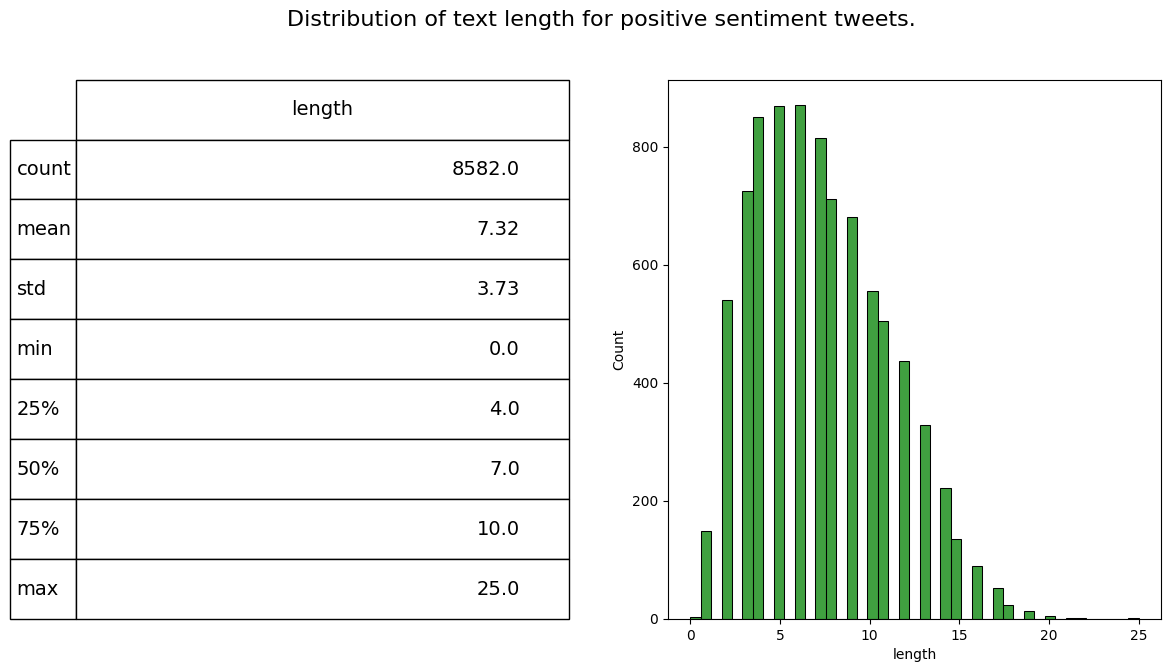

In [17]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='positive']['length'], ax=ax1,color='green')
describe = df.length[df.sentiment=='positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen positif. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen positif. pada sentimen positive, memiliki rata rata panjang kata sebesar `7.32` kata dengan minimal kata berada di `0` kata dan maksimal berada di `25` kata. Dengan melihat distribusi panjang kata, Apakah mayoritas tweet positif cenderung pendek, panjang, atau justru to the point jika dibandingkan dengan rata rata dengan sentimen negative ataupun neutral.

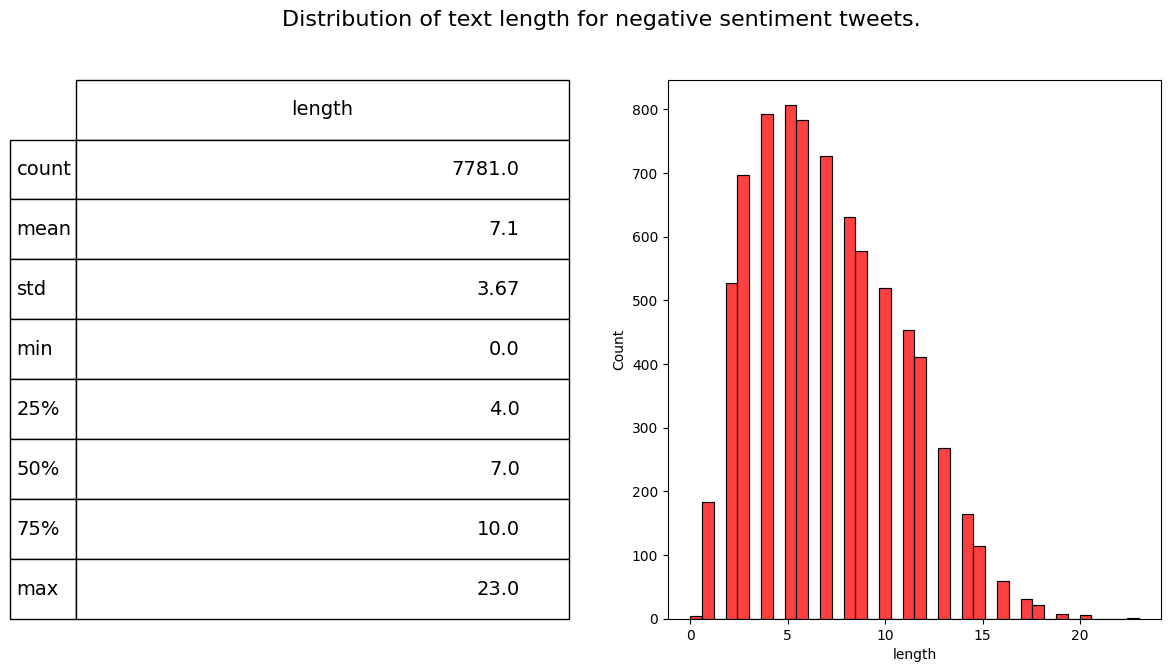

In [18]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='negative']['length'], ax=ax1,color='red')
describe = df.length[df.sentiment=='negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen negative. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen negative. pada sentimen negative, memiliki rata rata panjang kata sebesar `7.1` kata dengan minimal kata berada di `0` kata dan maksimal berada di `23` kata. Dengan melihat distribusi panjang kata, Apakah mayoritas tweet negative cenderung pendek, panjang, atau justru to the point jika dibandingkan dengan rata rata dengan sentimen positif ataupun neutral. jika dibandingkan data positive, panjang rata rata kata negative hampir sama dengan rata rata panjang kata positive.

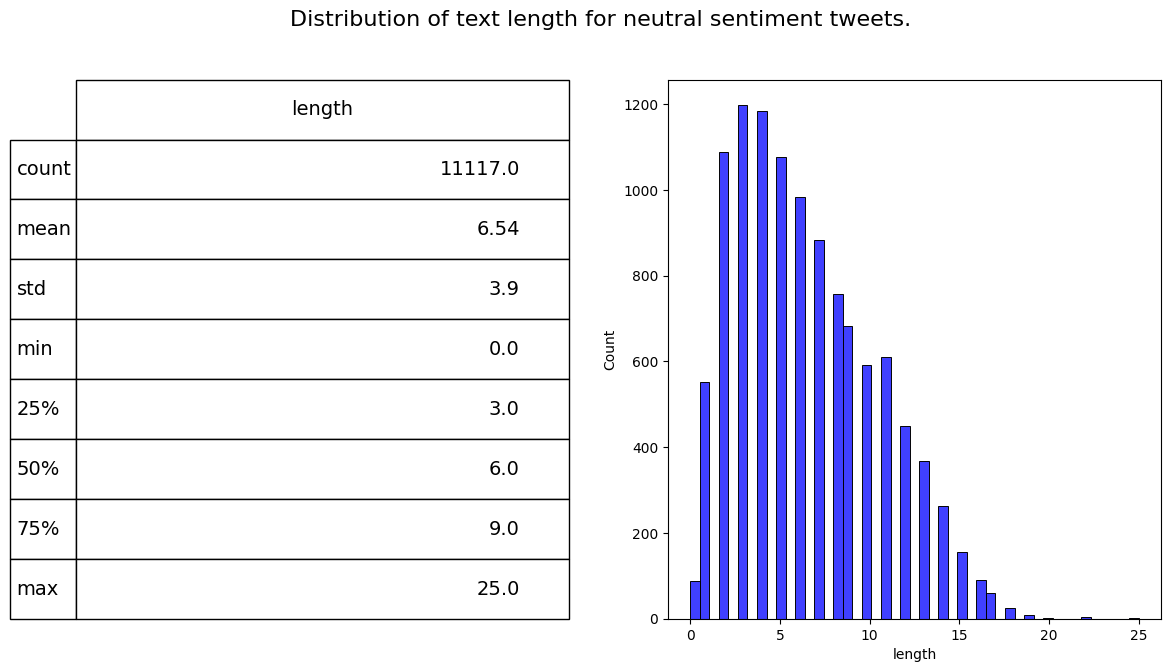

In [19]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']=='neutral']['length'], ax=ax1,color='blue')
describe = df.length[df.sentiment=='neutral'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral sentiment tweets.', fontsize=16)

plt.show()

**Insight** : Berikut merupakan visualisasi tentang panjang teks dalam tweet yang memiliki sentimen neutral. visualisasi ini menunjukkan Pemahaman tentang panjang rata-rata dapat memberikan wawasan tentang seberapa panjang atau pendek tweet yang umumnya dikaitkan dengan sentimen neutral. pada sentimen neutral, memiliki rata rata panjang kata sebesar `6.54` kata dengan minimal kata berada di `0` kata dan maksimal berada di `25` kata. Dengan melihat distribusi panjang kata, Apakah mayoritas tweet neutral cenderung pendek, panjang, atau justru to the point jika dibandingkan dengan rata rata dengan sentimen negative ataupun positif. jika dibandingkan data positive dan negative panjang rata rata kata neutral cenderung lebih pendek jika dibandingkan dengan kedua sentimen positive dan negative.

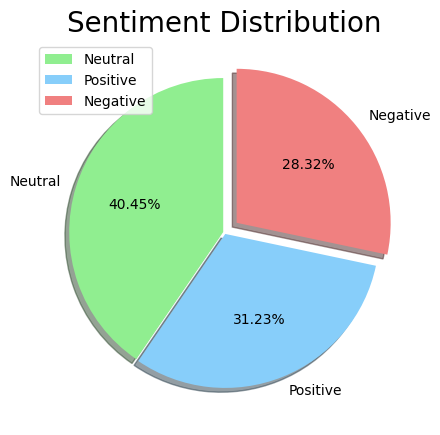

In [76]:
labels = ['Neutral', 'Positive', 'Negative']
size = df['sentiment'].value_counts()
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = [0.01, 0.01, 0.1]

fig, axes = plt.subplots(figsize=(6, 5))
plt.pie(size, colors = colors, explode = explode,
        labels = labels, shadow = True, startangle = 90, autopct = '%.2f%%')
plt.title('Sentiment Distribution', fontsize = 20)
plt.legend()
plt.show()

**Insight** :

Berdasarkan visualisasi distribusi sentimen, terlihat bahwa jumlah data dengan sentimen "Netral" mendominasi sebesar 40.45%, sedangkan jumlah data dengan sentimen "Positif" sebesar 31.23%, dan sentimen "Negatif" sebesar 28.32%. Dengan kata lain, kategori "Netral" memiliki jumlah data yang lebih besar dibandingkan dengan sentimen positif dan negatif.

## Data Splitting

In [43]:
# Display Target

df.label.unique()

array([2., 0., 1.])

**Insight** : Melihat unique target yang terdiri dari 2, 0, dan 1. karena target sudah dirubah kedalam bentuk numerik, proses ini mempermudah untuk pembentukan model selanjutnya.

In [23]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.text_processed,
                                                    df.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (21022,)
Val Size   :  (2336,)
Test Size  :  (4122,)


**Insight** : Proses pemisahan dataset (data splitting) menjadi bagian-bagian yang berbeda untuk keperluan pelatihan (training), validasi, dan pengujian (testing) menggunakan fungsi `train_test_split`.

- Train Size : (`21022`,), pelatihan ini memiliki 21,022 sampel data.
- Val Size : (`2336`,), Dataset validasi memiliki 2,336 sampel untuk mengevaluasi performa model di setiap epoch dan membantu menghindari overfitting
- Test Size : (`4122`,), Dataset pengujian memiliki 4,122 sampel. test size tidak digunakan pada pelatihan model, namun test size ini akan digunakan pada saat mengevaluasi data yang belum pernah dilihat sebelumnya.
- Parameter:
    - test_size=0.15 yang artinya melakukan pemisahan antara data pelatihan dan data pengujian, sebanyak 15% dari keseluruhan data digunakan untuk data pengujian.
    - test_size=0.10 yang artinya sebanyak 10% dari data pelatihan dan validasi digunakan sebagai data validasi. 
    - random_state=20 yang artinya ketika menjalankan kembali kode dengan parameter yang sama, hasil pemisahan dataset bisa konsisten atau sama seperti sebelumnya.
    - stratify= proporsi jumlah kategori atau label pada setiap bagian (pelatihan, validasi, dan pengujian) tetap serupa dengan proporsi kategori pada keseluruhan dataset. Hal ini bertujuan untuk mencegah adanya kecenderungan atau bias terhadap suatu kategori tertentu di salah satu bagian dataset.

In [64]:
# Change Target to One Hot Encoding

from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

**Insight** : proses one-hot encoding, setiap kategori sekarang direpresentasikan sebagai vektor biner, di mana satu elemen dalam vektor diatur sebagai 1 (menunjukkan kehadiran kategori) dan elemen lainnya adalah 0.

## Model Building

### Text Vectorization

In [26]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<21022x19861 sparse matrix of type '<class 'numpy.int64'>'
	with 140423 stored elements in Compressed Sparse Row format>

**Insight**: 

- CountVectorizer adalah untuk mengonversi teks menjadi representasi vektor berdasarkan frekuensi kemunculan kata (bag of words). Vectorize akan dipasangkan dengan metode fit_transform(X_train), di mana X_train adalah dataset teks pelatihan. Ini akan membangun kosakata (vocabulary) berdasarkan kata-kata yang muncul dalam dataset pelatihan dan mengonversi teks menjadi vektor berdasarkan frekuensi kemunculan kata-kata tersebut.

    - Matriks tersebut memiliki ukuran 21022x19861, yang berarti terdapat 21,022 sampel dalam dataset pelatihan dan 19,861 kata unik dalam kosakata (vocabulary) dengan Tipe matriks ini adalah "sparse matrix".
    - `140,423` yang artinya terdapat elemen yang tersimpan dalam matriks sparse.

In [65]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  19861
Maximum Sentence Length :  25 tokens


**Insight** :

memiliki Total Vocab sebanyak 19,861 kata unik, dan panjang Maximum Sentence Length adalah 25 kata. Informasi ini dapat digunakan untuk menyesuaikan parameter atau memahami karakteristik dataset sebelum melibatkan model pembelajaran mesin pada tugas tertentu.

In [28]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

**Insight** : 

Menggunakan TextVectorization untuk mengonversi teks ke dalam representasi vektor yang dapat digunakan oleh model neural network.
- Mempersiapkan pengolahan teks yang siap digunakan untuk model pembelajaran mesin dengan parameter yang sesuai dengan dataset pelatihan. dengan menggunakan parameter max_tokens, standardize, split, ngrams,output_mode, output_sequence_length.
- `adapt`, method ini untuk menyesuaikan TextVectorization dengan dataset X_train.


In [29]:
# Example Result

## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)

Document example
responded going

Result of Text Vectorization
tf.Tensor(
[[11533    11     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]], shape=(1, 25), dtype=int64)
Vector size :  (1, 25)


**Insight** :

- Dengan menggunakan TextVectorization, contoh dokumen teks (responded going) dapat diubah menjadi representasi vektor bilangan bulat yang dapat digunakan sebagai input untuk model pembelajaran mesin.

In [30]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'got',
 'love',
 'work',
 'today',
 'going',
 'one',
 'lol',
 'u',
 'happy',
 'time',
 'know',
 'really',
 'back']

**Insight** : berikut merupakan `get_vocabulary` dari `TextVectorization`, mencakup nilai token kosong, ataupun nilai yang tidak dikenal [UNK], dan beberapa kata lainnya.

### Word Embedding

In [31]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

**Insight** : 

Menggunakan layer Embedding, untuk membuat lapisan embedding kata pada model neural network. berikut penjelasan terkait konfirgurasi dari Embedding Layer :
1. input_dim = Jumlah kata dalam kosakata yang akan di-embedding
2. output_dim = Dimensi output embedding untuk setiap kata
3. embeddings_initializer = Inisialisasi bobot embedding 
4. input_length= Panjang maksimum dari setiap dokumen (dalam kata)

Layer ini dirancang untuk mengubah kata-kata dalam teks menjadi representasi vektor angka kontinu

In [32]:
# Example Result

## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df.text_processed[0]])).shape)

Document example
responded going

Result of  Text Vectorization
tf.Tensor(
[[11533    11     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]], shape=(1, 25), dtype=int64)
Vector size :  (1, 25)

Result of  Embedding
tf.Tensor(
[[[ 0.02568141 -0.03843901  0.00612335 ...  0.03699635  0.0447319
   -0.02577909]
  [ 0.0467121   0.04176025  0.03234892 ... -0.03178369  0.04745512
   -0.02485089]
  [-0.02767544 -0.02841611  0.01763927 ... -0.00500327  0.03282574
    0.0226371 ]
  ...
  [-0.02767544 -0.02841611  0.01763927 ... -0.00500327  0.03282574
    0.0226371 ]
  [-0.02767544 -0.02841611  0.01763927 ... -0.00500327  0.03282574
    0.0226371 ]
  [-0.02767544 -0.02841611  0.01763927 ... -0.00500327  0.03282574
    0.0226371 ]]], shape=(1, 25, 128), dtype=float32)
Vector size :  (1, 25, 128)


**Insight** :

Output menghasilkan bagaimana teks "responded going." diubah menjadi representasi numerik dengan dua langkah:
1. menggunakan TextVectorization untuk mendapatkan vektor bilangan bulat.
2. menggunakan layer Embedding untuk mengonversi vektor tersebut menjadi representasi vektor kontinu dengan dimensi 128.

## ANN Training

### Model Using LSTM

In [34]:
# Model Training using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping

callbacks_1= [
    EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
model_lstm_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 25)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 25, 128)           2542208   
                                                                 
 bidirectional (Bidirection  (None, 25, 64)            41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                        

**Insight** :

Berikut merupakan sebuah model neural network menggunakan (Long Short-Term Memory), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.
- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 3 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.
- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan LSTM dengan arah `Bidirectional` dengan ukuran 32 dan 16. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(3Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dan metrik akurasi.

In [ ]:
# # Plot layers

tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

In [35]:
model_lstm_1_hist = model_lstm_1.fit(X_train,
                                     y_train_ohe,
                                     epochs=50,
                                     callbacks= callbacks_1,
                                     validation_data=(X_val, y_val_ohe))

Epoch 1/50
657/657 [==============================] - 37s 43ms/step - loss: 0.8149 - accuracy: 0.6295 - val_loss: 0.7478 - val_accuracy: 0.6789
Epoch 2/50
657/657 [==============================] - 27s 41ms/step - loss: 0.5554 - accuracy: 0.7815 - val_loss: 0.7396 - val_accuracy: 0.6931
Epoch 3/50
657/657 [==============================] - 26s 39ms/step - loss: 0.3849 - accuracy: 0.8592 - val_loss: 0.8365 - val_accuracy: 0.6708
Epoch 4/50
657/657 [==============================] - 25s 37ms/step - loss: 0.2789 - accuracy: 0.9034 - val_loss: 1.0363 - val_accuracy: 0.6610
Epoch 5/50
657/657 [==============================] - 25s 38ms/step - loss: 0.2046 - accuracy: 0.9298 - val_loss: 1.1987 - val_accuracy: 0.6485


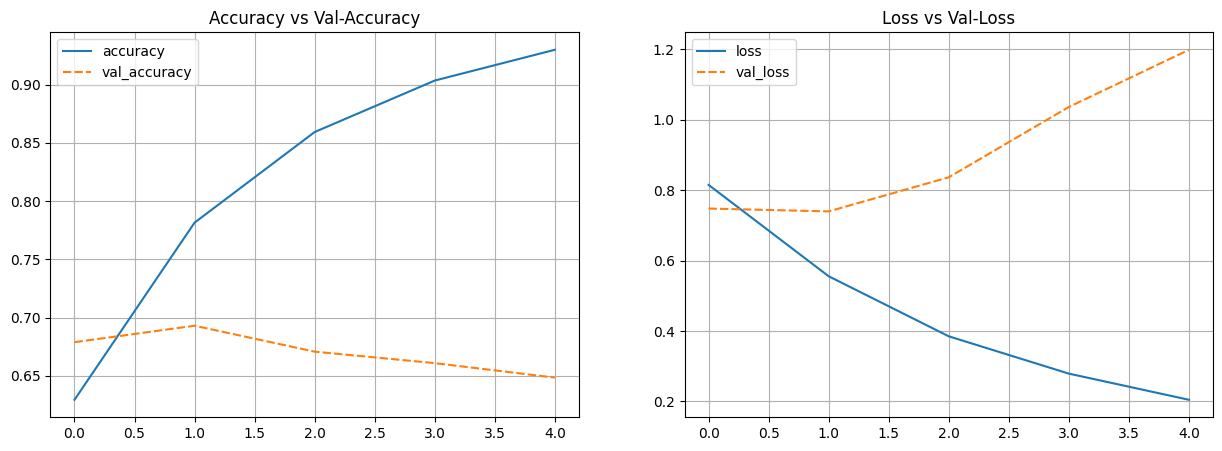

In [36]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight** :

Insight dari visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model LSTM. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 92.98%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 64.85%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 0.2046.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 1.1987.

 Model mengalami overfitting. Ini terlihat dari perbedaan yang signifikan antara performa pada data pelatihan dan data validasi. Meskipun model mampu dengan baik menggeneralisasi pada data pelatihan, performanya menurun ketika diterapkan pada data yang tidak dilihat selama pelatihan, seperti data validasi. Oleh karena itu, model ini memerlukan beberapa penyesuaian atau tindakan pencegahan overfitting, mungkin dengan menggunakan teknik seperti dropout lebih lanjut, pengurangan kompleksitas model, atau penambahan data pelatihan tambahan jika memungkinkan dan memastikan dataset memiliki jumlah sampel yang cukup dan beragam.

### Model Using GRU

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Bidirectional, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture with GRU
model_gru_best = Sequential()
model_gru_best.add(text_vectorization)
model_gru_best.add(embedding)
model_gru_best.add(Bidirectional(GRU(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                recurrent_regularizer=regularizers.l2(0.01))))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Bidirectional(GRU(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                recurrent_regularizer=regularizers.l2(0.01))))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model_gru_best.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics='accuracy')

model_gru_best.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 25)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 25, 128)           2542208   
                                                                 
 bidirectional (Bidirection  (None, 25, 128)           74496     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 25, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                        

**Insight** :

Berikut merupakan sebuah model neural network menggunakan GRU (Gated Recurrent Unit), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.
- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 3 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.
- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan GRU dengan arah `Bidirectional` dengan ukuran 64 dan 32. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - Dua layer Dense (fully connected) yang memiliki fungsi aktivasi 'relu', dengan dropout dan regularisasi L2, untuk memproses dan menyederhanakan fitur-fitur yang diambil dari GRU layers.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(3Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dengan laju pembelajaran 0.001, dan metrik akurasi.

In [72]:
model_gru_best_hist = model_gru_best.fit(X_train,
                                   y_train_ohe,
                                   epochs=50,
                                   callbacks=callbacks_1,
                                   validation_data=(X_val, y_val_ohe))

Epoch 1/50
657/657 [==============================] - 37s 44ms/step - loss: 0.8166 - accuracy: 0.8472 - val_loss: 1.0513 - val_accuracy: 0.6348
Epoch 2/50
657/657 [==============================] - 27s 40ms/step - loss: 0.4320 - accuracy: 0.8921 - val_loss: 1.0332 - val_accuracy: 0.6327
Epoch 3/50
657/657 [==============================] - 27s 42ms/step - loss: 0.3647 - accuracy: 0.9140 - val_loss: 1.1208 - val_accuracy: 0.6327
Epoch 4/50
657/657 [==============================] - 27s 41ms/step - loss: 0.3275 - accuracy: 0.9257 - val_loss: 1.2061 - val_accuracy: 0.6306
Epoch 5/50
657/657 [==============================] - 29s 45ms/step - loss: 0.2928 - accuracy: 0.9377 - val_loss: 1.2433 - val_accuracy: 0.6147


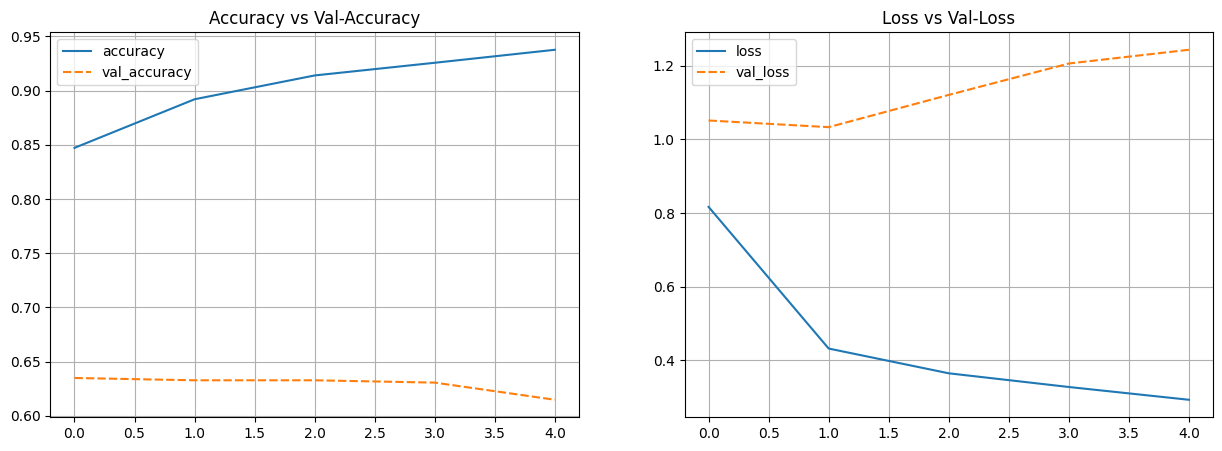

In [73]:
# Plot Training Results

model_gru_best_hist_df = pd.DataFrame(model_gru_best_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_best_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_best_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight** :

Insight dari visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model GRU. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 93.77%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 61.47%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 0.2928.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 1.2433.

 Model mengalami overfitting. Ini terlihat dari perbedaan yang signifikan antara performa pada data pelatihan dan data validasi. Meskipun model mampu dengan baik menggeneralisasi pada data pelatihan, performanya menurun ketika diterapkan pada data yang tidak dilihat selama pelatihan, seperti data validasi. Oleh karena itu, model ini memerlukan beberapa penyesuaian atau tindakan pencegahan overfitting, mungkin dengan menggunakan teknik seperti dropout lebih lanjut, pengurangan kompleksitas model, atau penambahan data pelatihan tambahan jika memungkinkan dan memastikan dataset memiliki jumlah sampel yang cukup dan beragam.

## ANN Improvement

### LSTM with Transfer Learning

In [36]:
# Download the Embedding Layer
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

**Insight** :

Transfer Learning menggunakan TensorFlow Hub. TensorFlow Hub untuk mengambil lapisan embedding dari model transfer learning teks berdimensi 128 dengan normalisasi yang telah dilatih sebelumnya
Lapisan ini diterapkan sebagai bagian dari arsitektur model, memungkinkan model memanfaatkan pengetahuan dari data teks yang luas yang telah diajarkan sebelumnya. `Hal ini dapat meningkatkan kemampuan model dalam memahami dan merepresentasikan teks`.


In [38]:
# Model Training using LSTM with Transfer Learning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(3, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train,
                                     y_train_ohe,
                                     epochs=50,
                                    callbacks=callbacks_1,
                                     validation_data=(X_val, y_val_ohe))

Epoch 1/50
657/657 [==============================] - 69s 91ms/step - loss: 1.0718 - accuracy: 0.4262 - val_loss: 1.0578 - val_accuracy: 0.4456
Epoch 2/50
657/657 [==============================] - 57s 86ms/step - loss: 1.0485 - accuracy: 0.4569 - val_loss: 1.0316 - val_accuracy: 0.4747
Epoch 3/50
657/657 [==============================] - 70s 107ms/step - loss: 1.0348 - accuracy: 0.4715 - val_loss: 1.0157 - val_accuracy: 0.4927
Epoch 4/50
657/657 [==============================] - 58s 88ms/step - loss: 1.0089 - accuracy: 0.4956 - val_loss: 1.0016 - val_accuracy: 0.5098
Epoch 5/50
657/657 [==============================] - 55s 83ms/step - loss: 0.9946 - accuracy: 0.5089 - val_loss: 0.9904 - val_accuracy: 0.5124
Epoch 6/50
657/657 [==============================] - 56s 85ms/step - loss: 0.9859 - accuracy: 0.5213 - val_loss: 0.9765 - val_accuracy: 0.5210
Epoch 7/50
657/657 [==============================] - 58s 88ms/step - loss: 0.9796 - accuracy: 0.5217 - val_loss: 0.9666 - val_accuracy

**Insight** :

Berikut merupakan sebuah model neural network menggunakan (Long Short-Term Memory), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.
- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 3 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.
- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan LSTM dengan arah `Bidirectional` dengan ukuran 32 dan 16. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(3Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dan metrik akurasi.

Dengan menggunakan Transfer Learning TensorFlow Hub, model dapat memanfaatkan pengetahuan yang telah diperoleh dari model transfer learning sebelumnya, memperkaya representasi teks dan meningkatkan kemampuan model dalam tugas klasifikasi.

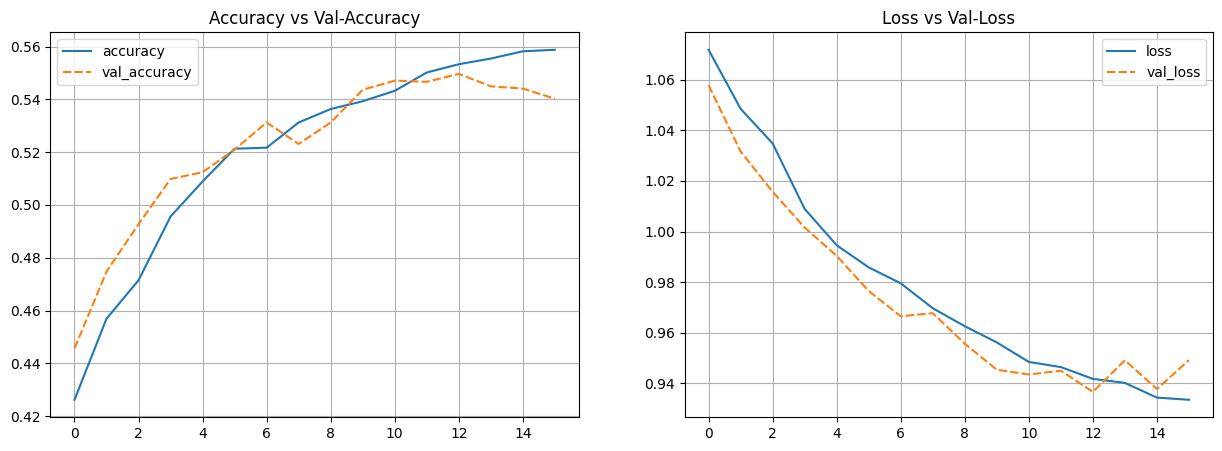

In [39]:
# Plot Training Results

model_lstm_2_hist_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight** :

visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model LSTM dengan memanfaatkan transfer learning. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 55.88%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 54.02%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 0.9336.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 0.9493.

Model tidak menunjukkan gejala overfitting, karena perbedaan antara akurasi pada data pelatihan dan data validasi relatif kecil, Meskipun model tidak overfitting, akurasi yang dihasilkan cenderung kecil. Hal ini dapat disebabkan oleh kompleksitas tugas klasifikasi atau kebutuhan penyesuaian lebih lanjut pada arsitektur model. Melihat akurasi yang masih terbatas, model ini dapat diperbaiki dengan menyesuaikan hyperparameter, menambahkan lapisan atau mengubah struktur arsitektur model, dan melibatkan lebih banyak data pelatihan untuk meningkatkan generalisasi. Penting untuk memastikan dataset memiliki jumlah sampel yang memadai dan beragam. 

### GRU With Transfer Learning

In [40]:
# Download the Embedding Layer
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

**Insight** :

Transfer Learning menggunakan TensorFlow Hub. TensorFlow Hub untuk mengambil lapisan embedding dari model transfer learning teks berdimensi 128 dengan normalisasi yang telah dilatih sebelumnya
Lapisan ini diterapkan sebagai bagian dari arsitektur model, memungkinkan model memanfaatkan pengetahuan dari data teks yang luas yang telah diajarkan sebelumnya. `Hal ini dapat meningkatkan kemampuan model dalam memahami dan merepresentasikan teks`.


In [42]:
# Model Training using GRU with Transfer Learning

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_gru_2 = Sequential()
model_gru_2.add(hub_layer)
model_gru_2.add(Reshape((128, 1)))
model_gru_2.add(Bidirectional(GRU(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru_2.add(Dropout(0.1))
model_gru_2.add(Bidirectional(GRU(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru_2.add(Dropout(0.1))
model_gru_2.add(Dense(3, activation='softmax'))

model_gru_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_gru_2_hist = model_gru_2.fit(X_train,
                                   y_train_ohe,
                                   epochs=50,
                                   callbacks=callbacks_1,
                                   validation_data=(X_val, y_val_ohe))

Epoch 1/50
657/657 [==============================] - 85s 113ms/step - loss: 1.0579 - accuracy: 0.4398 - val_loss: 1.0150 - val_accuracy: 0.4906
Epoch 2/50
657/657 [==============================] - 61s 93ms/step - loss: 1.0083 - accuracy: 0.5009 - val_loss: 0.9812 - val_accuracy: 0.5146
Epoch 3/50
657/657 [==============================] - 63s 96ms/step - loss: 0.9882 - accuracy: 0.5160 - val_loss: 0.9760 - val_accuracy: 0.5158
Epoch 4/50
657/657 [==============================] - 71s 108ms/step - loss: 0.9824 - accuracy: 0.5249 - val_loss: 0.9798 - val_accuracy: 0.5043
Epoch 5/50
657/657 [==============================] - 70s 106ms/step - loss: 0.9748 - accuracy: 0.5319 - val_loss: 0.9674 - val_accuracy: 0.5248
Epoch 6/50
657/657 [==============================] - 65s 99ms/step - loss: 0.9652 - accuracy: 0.5366 - val_loss: 0.9498 - val_accuracy: 0.5441
Epoch 7/50
657/657 [==============================] - 68s 104ms/step - loss: 0.9589 - accuracy: 0.5389 - val_loss: 0.9515 - val_accur

**Insight** :

Berikut merupakan sebuah model neural network menggunakan (Gated Recurrent Unit), berikut sedikit penjelasan terkait  arsitektur model yang dibuat.
- Callback : model ini menggunakan teknik EarlyStopping sebagai callback untuk menghentikan pelatihan jika tidak terjadi perbaikan, perbaikan ini berfokus pada `val_loss` setelah 3 epoch, dan callback ini untuk memulihkan bobot terbaik dari model.
- Clear Session : Dilakukan pembersihan `tf.keras.backend.clear_session()` untuk memastikan konsistensi dari sebuah model. lalu seed diatur untuk memastikan hasil pelatihan yang di reproduksi. seed merupakan nilai awal yang digunakan untuk menginisialisasi generator angka acak.
- Arsitektur Model :
    - Model Menggunakan Sequential untuk menentukan urutan layer.
    - layer pertama adalah `text_vectorization` yang sudah dibangun sebelumnya untuk mengkonversi sebuah text menjadi representasi vektor.
    - Lalu dilayer kedua adalah `Embedding` yang mengubah vektor angka dengan dimensi 128
    - lalu 2 layer dengan LSTM dengan arah `Bidirectional` dengan ukuran 32 dan 16. `Bidirectional` yang dimaksud disini adalah untuk pemrosesan urutan dalam dua arah, yang dapat membantu model dalam memahami konteks teks dengan lebih baik.
    - lalu menggunakan `Dropout` untuk menghindari terjadinya Overfit pada model
    - Lapisan terakhir adalah `Dense` dengan menggunakan activasion `Softmax` untuk klasifikasi multikelas(3Kelas). activasion `Softmax` ini merupakan suatu fungsi matematis yang digunakan di lapisan output dari model neural network untuk masalah klasifikasi multikelas.
- Model compile : model dicompile menggunakan fungsi loss `categorical_crossentropy ` untuk klasifikasi multikelas, optimizer `adam`, dan metrik akurasi.

Dengan menggunakan Transfer Learning TensorFlow Hub, model dapat memanfaatkan pengetahuan yang telah diperoleh dari model transfer learning sebelumnya, memperkaya representasi teks dan meningkatkan kemampuan model dalam tugas klasifikasi.

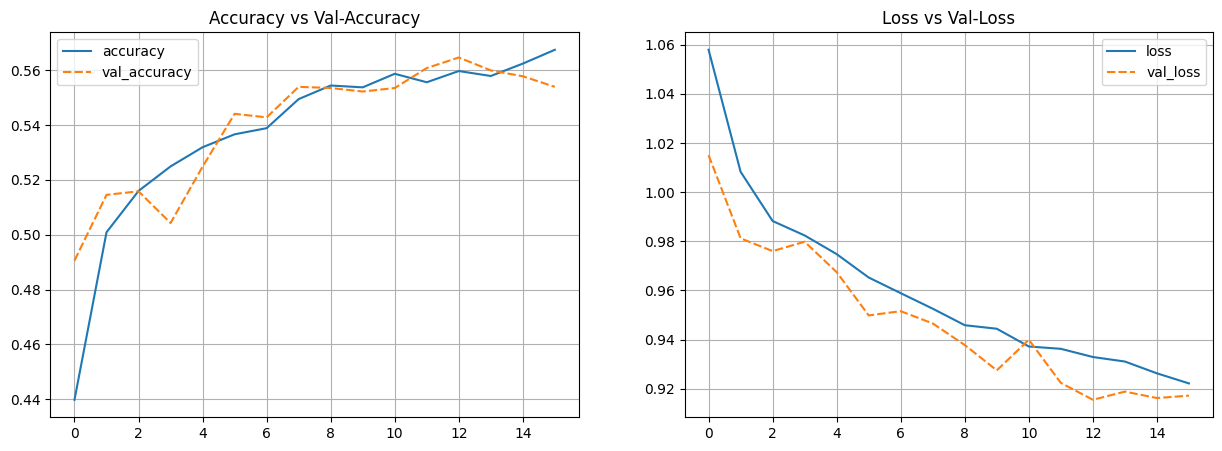

In [43]:
# Plot Training Results

model_gru_2_hist_df = pd.DataFrame(model_gru_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight** :

visualisasi di atas menunjukkan nilai accuracy, val_accuracy, loss, dan val_loss selama proses pelatihan model GRU dengan memanfaatkan transfer learning. Dengan nilai akhir sebagai berikut:

- Akurasi dan Val-Akurasi:
    - Akurasi pada data pelatihan (accuracy) mencapai sekitar 56.75%.
    - Akurasi pada data validasi (val_accuracy) mencapai sekitar 55.39%.

- Loss dan Val-Loss:
    - Loss pada data pelatihan (loss) mencapai nilai sekitar 0.9221.
    - Loss pada data validasi (val_loss) mencapai nilai sekitar 0.9172.

Model tidak menunjukkan gejala overfitting, karena perbedaan antara akurasi pada data pelatihan dan data validasi relatif kecil, Meskipun model tidak overfitting, akurasi yang dihasilkan cenderung kecil. Hal ini dapat disebabkan oleh kompleksitas tugas klasifikasi atau kebutuhan penyesuaian lebih lanjut pada arsitektur model. Melihat akurasi yang masih terbatas, model ini dapat diperbaiki dengan menyesuaikan hyperparameter, menambahkan lapisan atau mengubah struktur arsitektur model, dan melibatkan lebih banyak data pelatihan untuk meningkatkan generalisasi. Penting untuk memastikan dataset memiliki jumlah sampel yang memadai dan beragam. 

## Saving Model

Untuk proses saving model. model yang akan digunakan merupakan model yang dibandingkan dari model ANN training dan model ANN Improvement. karena model ANN Training mengalami overfit, maka saya memutuskan untuk menggunakan model ANN Improvement menggunakan Transferlearning walaupun akurasi tidak baik tapi model tidak mengalami overfit seperti ANN training. model yang akan di save merupakan Model GRU dengan Transferlearning.

In [44]:
model_gru_2.save('model_gru_2', save_format='tf')

INFO:tensorflow:Assets written to: model_gru_2\assets


INFO:tensorflow:Assets written to: model_gru_2\assets


**Insight** : Model GRU (model_gru_2) disimpan ke dalam direktori dengan nama 'model_gru_2' sebagai format TensorFlow SavedModel.

## Model Inference

Setelah menyimpan model dalam bentuk file, kita bisa memanggilnya kembali untuk menguji bagaimana model melakukan prediksi. Ini sangat membantu untuk mengevaluasi seberapa baik model bekerja dan bagaimana kemampuannya memprediksi data baru. Dengan cara ini, kita bisa menilai seberapa akurat model dalam menghadapi situasi dunia nyata. Proses ini menjadi kunci untuk memastikan dan menguji model GRU yang sudah kita latih sebelumnya.

In [102]:
import pandas as pd
from keras.models import load_model
import numpy as np

# Load Model
model = load_model('model_gru_2')

# Input Text
input_text = "you are amazing"

# Make a prediction using model
predictions = model.predict(np.array([input_text]))

predicted_class = np.argmax(predictions[0])

# Map predicted class to labels
class_labels = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
predicted_label = class_labels[predicted_class]

# Display the results
print("Input Text:", input_text)
print("Predicted Class:", predicted_class)
print("Predicted Label:", predicted_label)
print("Prediction Probabilities:", predictions[0])

# Create a DataFrame to store the results
columns = ['Input Text', 'Predicted Class', 'Predicted Label', 'Prediction Probabilities']
data = [[input_text, predicted_class, predicted_label, predictions[0]]]
result_df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
print("\nResult DataFrame:")
print(result_df)



1/1 [==============================] - 2s 2s/step
Input Text: you are amazing
Predicted Class: 1
Predicted Label: Positive
Prediction Probabilities: [0.18456388 0.5119029  0.3035332 ]

Result DataFrame:
        Input Text  Predicted Class Predicted Label  \
0  you are amazing                1        Positive   

             Prediction Probabilities  
0  [0.18456388, 0.5119029, 0.3035332]  


**insight** :

1. Proses inferensi data bertujuan untuk menguji sejauh mana mengklasifikasikan sentimen dari teks yang diberikan, serta sejauh mana model yakin dengan prediksi yang dihasilkan menggunakan dummy data.
2. pada data inference. dummy Teks yang digunakan sebagai input untuk model adalah "`you are amazing`", Kelas yang diprediksi oleh model adalah kelas dengan nilai 1, Label yang sesuai dengan kelas yang diprediksi adalah "Positive". Dalam konteks ini, kelas 1 diinterpretasikan sebagai sentimen positif. jika dilihat dari Probabilitas prediksi untuk masing-masing kelas. Dalam hal ini, model memberikan probabilitas sekitar 18.46% untuk kelas 0 (Negatif), 51.19% untuk kelas 1 (Positif), dan 30.35% untuk kelas 2 (Netral). maka dari itu model di prediksi sebagai class 1 atau Positive

## Kesimpulan

Dalam eksplorasi dan pengembangan model untuk tugas klasifikasi sentimen, model yang dipilih adalah GRU (Gated Recurrent Unit) dengan memanfaatkan transfer learning menggunakan TensorFlow Hub. Berikut adalah kesimpulan dari model ini:

**A**
1. Transfer Learning dengan TensorFlow Hub:
    - Model memanfaatkan lapisan embedding dari TensorFlow Hub, yang telah dilatih sebelumnya untuk memahami representasi teks dengan lebih baik.
2. Struktur Arsitektur Model:
    - Arsitektur model GRU yang digunakan melibatkan beberapa lapisan, termasuk lapisan text_vectorization, lapisan Embedding dengan dimensi 128, dan dua lapisan GRU bidirectional untuk pemrosesan urutan yang lebih baik.
    - Teknik dropout juga diterapkan untuk mencegah overfitting pada model.
3. Pelatihan dan Evaluasi Model:
    - Model telah diinstruksikan untuk menghentikan pelatihan jika tidak terjadi perbaikan dalam val_loss setelah 3 epoch, menggunakan teknik EarlyStopping.
    - Evaluasi model dilakukan dengan melihat metrik akurasi, loss, dan visualisasi grafik akurasi dan loss selama proses pelatihan.
4. Hasil dan Performa Model:
    - Model berhasil dilatih dan dievaluasi dengan hasil yang cukup.
    - Hasil evaluasi model tidak menunjukkan tanda-tanda overfitting, namun akurasi yang dihasilkan pada data validasi cenderung terbatas/kecil.
5. Kelebihan: 
    - Model dapat memanfaatkan pengetahuan yang telah diperoleh dari model transfer learning sebelumnya melalui lapisan embedding TensorFlow Hub. Hal ini membantu dalam memahami konteks dan merepresentasikan teks dengan lebih kaya, dan mampung menghindari dari overfitting.
6. Kelemahan:
    - Akurasi Terbatas pada Data Validasi :
        - Meskipun model tidak menunjukkan gejala overfitting, akurasi pada data validasi masih terbatas. Ini mungkin memerlukan penyesuaian lebih lanjut pada hyperparameter atau struktur model untuk meningkatkan kinerja.
    - Keterbatasan pada Jumlah Data Pelatihan:
        - Kinerja model dapat dipengaruhi oleh jumlah data pelatihan yang terbatas. Penambahan data pelatihan tambahan dapat membantu dalam meningkatkan generalisasi model.
7. Batasan:
    - Data Pelatihan Terbatas:
        - Jumlah sampel yang kurang dapat menyulitkan model untuk memahami variasi yang mungkin terjadi di lingkungan produksi.
    
**B**
Dari hasil prediksi model yang telah dibangun dan dilatih, dapat disimpulkan bahwa model memprediksi sentiment dengan nilai `1`, dummy Teks yang digunakan sebagai input untuk model adalah "`you are amazing`" yang artinya bahwa text yang tulis menandakan sentiment `Positive`